In [1]:
library(tidyverse)
library(plyr)
library(ggrepel)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following object is masked from ‘package:purrr’:

    compact




In [2]:
code_dir <- getwd()
tool_dir <- unlist(strsplit(code_dir,"/"))
tool_dir <- head(tool_dir, length(tool_dir)-1)
tool_dir <- paste(c(tool_dir, "tools"), collapse="/")
source(file.path(tool_dir, "pl_functions.R"))
base_dir <- gsub("/plotting_codes", "", code_dir)
base_dir


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Parsed with column specification:
cols(
  gs_name = col_character(),
  type = col_character(),
  use = col_character(),
  plot_use = col_character(),
  abbr = col_character(),
  order = col_double()
)

Parsed with column specification:
cols(
  gs_name = col_character(),
  gene_symbol = col_character()
)



[1] "/media/pipkin/ROCKET-PRO/CD8_DEV_SC"

In [3]:
exp_name <- "0_Acute-Chronic"
analysis_name <- c("0", "resampled") 

use.path <- file.path(base_dir, '9_Figures', exp_name, 
                      paste(analysis_name, collapse="_"),
                      'volcano_plots')
dir.create(use.path, showWarnings = FALSE, recursive=TRUE)
setwd(use.path)

In [4]:
label.file <- file.path(base_dir,'/0_Acute-Chronic/2_scVelo/0_scVelo_out_resampledNoDyn/pt_ordered_cluster_avg.csv')
label.df <- read_csv(label.file)

Parsed with column specification:
cols(
  louvain = col_double(),
  initial_size_spliced = col_double(),
  initial_size_unspliced = col_double(),
  initial_size = col_double(),
  n_counts = col_double(),
  dpt_pseudotime = col_double(),
  velocity_self_transition = col_double(),
  root_cells = col_double(),
  end_points = col_double(),
  velocity_pseudotime = col_double(),
  louvain_new_label = col_character()
)



*GSEA selection*

## 0. All cells: cluster v.s. cluster

In [8]:
de.dir <- '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/1_Scanpy/0_Scanpy_out_resampled/2_DE/Cluster_vs_Cluster'

In [173]:
source(file.path(tool_dir, "pl_functions.R"))

Parsed with column specification:
cols(
  gs_name = col_character(),
  type = col_character(),
  use = col_character(),
  plot_use = col_character(),
  abbr = col_character(),
  order = col_double()
)

Parsed with column specification:
cols(
  gs_name = col_character(),
  gene_symbol = col_character()
)



Parsed with column specification:
cols(
  gene_names = col_character(),
  `3` = col_double(),
  `6` = col_double(),
  wilcoxon_logfc = col_double(),
  wilcoxon_padj = col_double(),
  wilcoxon_score = col_double(),
  `t-test_logfc` = col_double(),
  `t-test_padj` = col_double(),
  `t-test_score` = col_double(),
  `t-test_overestim_var_logfc` = col_double(),
  `t-test_overestim_var_padj` = col_double(),
  `t-test_overestim_var_score` = col_double()
)



  side TE up Naive up
1   up    17        6
2   dn     2      128


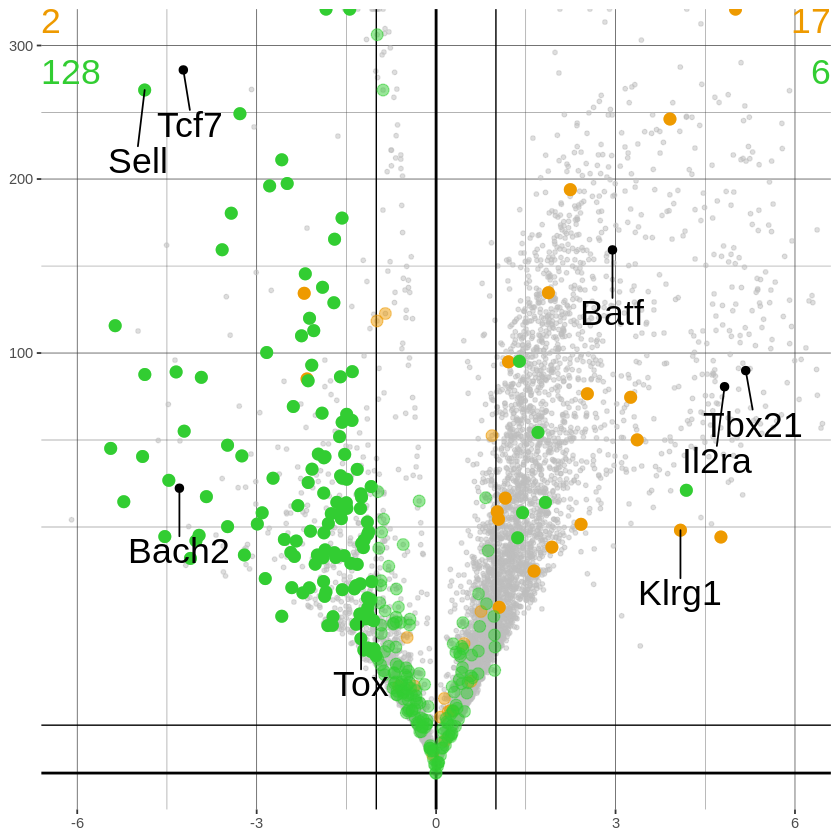

In [175]:
cp <- c("P2", "P0")
cp_oldnames <- cvt_names(cp, label.df$louvain_new_label, label.df$louvain)
cp_oldnames <- as.character(cp_oldnames)

###----- Setup
outname.base <- paste("All", cp[1], "vs", cp[2], sep="_")
use.genes <- c("Tbx21", "Il2ra", "Batf", "Tox", "Bach2", "Tcf7", "Tox","Batf3", "Klrg1", "Sell", "Cd127")
log2fc.c <- 1
nlog10p.c <- 1.3
gs.vec <- c("TE up", "Naive up")
gs.col.vec <- c("orange2", "limegreen")

###----- Plot
# Read input
louvain.de.file <- paste(cp_oldnames[1], "vs", cp_oldnames[2], "differential.csv", sep="_")
louvain.de.file <- file.path(de.dir, file.path(cp_oldnames[1], louvain.de.file))
de.df <- read_csv(louvain.de.file)
# Filter out low expression & convert df for plotting
de.df <- de.df %>% 
  mutate(max_expr = pmax(pull(de.df, cp_oldnames[1]), pull(de.df, cp_oldnames[2]))) %>% filter(max_expr > 0.15) %>%
  drop_na() %>% select(one_of('gene_names', 't-test_logfc', 't-test_padj'))
colnames(de.df) <- c("gene_name", "log2fc", "padj")
de.df$nlog10pval <- -log10(de.df$padj)

# Plot 
vol_plot_out <- volcano_plot_highlightGSEA(de.df, use.genes, gs.vec, gs.col.vec, log2fc.c, nlog10p.c) # With label
vol_plot <- vol_plot_out$plot
vol_plot
ggsave(paste(outname.base, ".png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')

# Save simplified plot
vol_plot <- vol_plot + theme(axis.text.x=element_blank(), axis.text.y=element_blank()) # Without label
ggsave(paste(outname.base, "_nolabel.png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')

# Save summary
write_csv(vol_plot_out$sum, paste(outname.base, "_sum.csv", sep=""))

In [176]:
get_gs_genes()

[1] "Possible signatures for using:"
 [1] "48h Act up"     "DP up"          "EE up"          "Tex dn"        
 [5] "Tex up"         "JJM_Tcm"        "JJM_Trm"        "Rao_MEM"       
 [9] "MP up"          "Naive up"       "TE up"          "Tex_int down"  
[13] "Tex_int up"     "Tex prog1 down" "Tex prog1 up"   "Tex prog2 down"
[17] "Tex prog2 up"   "Tex_term dn"    "Tex_term up"    "Tstem"         
[21] "Best_1"         "Best_10"        "Best_2"         "Best_3"        
[25] "Best_4"         "Best_5"         "Best_6"         "Best_7"        
[29] "Best_8"         "Best_9"         "Day5KLRG1hi up" "TRM_vs_TCM-TEM"
[33] "TCM_vs_TEM-TRM" "Day5KLRG1lo up" "TEM_vs_TCM-TRM"


Parsed with column specification:
cols(
  gene_names = col_character(),
  `6` = col_double(),
  `7` = col_double(),
  wilcoxon_logfc = col_double(),
  wilcoxon_padj = col_double(),
  wilcoxon_score = col_double(),
  `t-test_logfc` = col_double(),
  `t-test_padj` = col_double(),
  `t-test_score` = col_double(),
  `t-test_overestim_var_logfc` = col_double(),
  `t-test_overestim_var_padj` = col_double(),
  `t-test_overestim_var_score` = col_double()
)



  side Tstem TRM_vs_TCM-TEM
1   up    48             49
2   dn     1            147


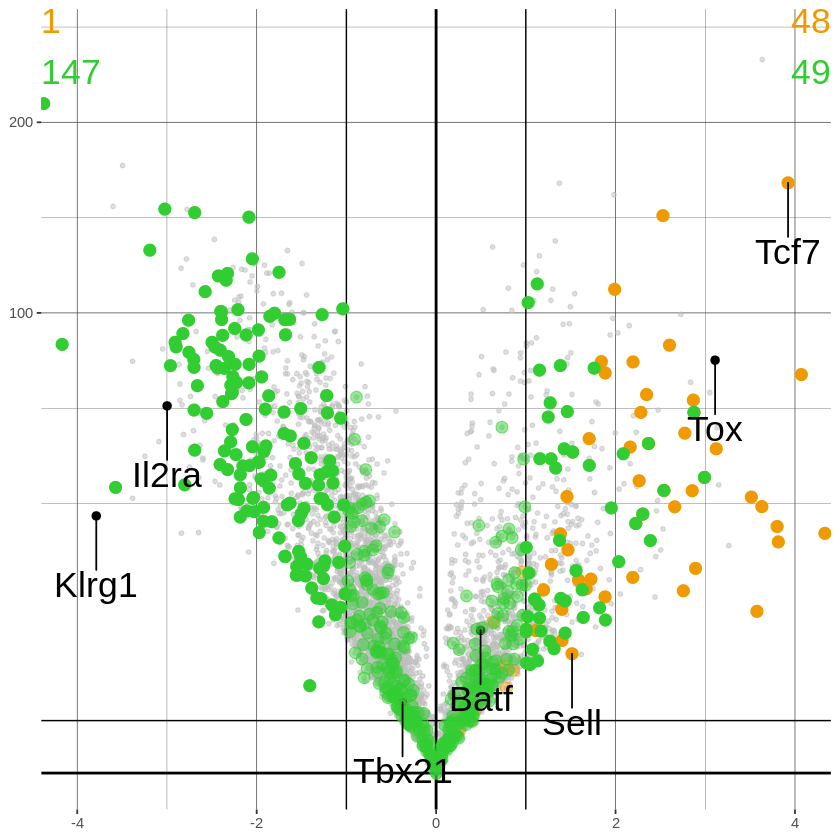

In [181]:
cp <- c("P7", "P2")
cp_oldnames <- cvt_names(cp, label.df$louvain_new_label, label.df$louvain)
cp_oldnames <- as.character(cp_oldnames)

###----- Setup
outname.base <- paste("All", cp[1], "vs", cp[2], sep="_")
use.genes <- c("Tbx21", "Il2ra", "Batf", "Tox", "Bach2", "Tcf7", "Tox","Batf3", "Klrg1", "Sell", "Cd127")
log2fc.c <- 1
nlog10p.c <- 1.3
gs.vec <- c("Tstem", "TRM_vs_TCM-TEM")
gs.col.vec <- c("orange2", "limegreen")
log2fc.range <- c(-4,4)
nlog10pval.max <- 250

###----- Plot
# Read input
louvain.de.file <- paste(cp_oldnames[1], "vs", cp_oldnames[2], "differential.csv", sep="_")
louvain.de.file <- file.path(de.dir, file.path(cp_oldnames[1], louvain.de.file))
de.df <- read_csv(louvain.de.file)
# Filter out low expression & convert df for plotting
de.df <- de.df %>% 
  mutate(max_expr = pmax(pull(de.df, cp_oldnames[1]), pull(de.df, cp_oldnames[2]))) %>% filter(max_expr > 0.15) %>%
  drop_na() %>% select(one_of('gene_names', 't-test_logfc', 't-test_padj'))
colnames(de.df) <- c("gene_name", "log2fc", "padj")
de.df$nlog10pval <- -log10(de.df$padj)
# Plot 
vol_plot_out <- volcano_plot_highlightGSEA(de.df, use.genes, gs.vec, gs.col.vec, 
                                           log2fc.c, nlog10p.c,log2fc.range, nlog10pval.max) # With label
vol_plot <- vol_plot_out$plot
vol_plot
ggsave(paste(outname.base, ".png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')

# Save simplified plot
vol_plot <- vol_plot + theme(axis.text.x=element_blank(), axis.text.y=element_blank()) # Without label
ggsave(paste(outname.base, "_nolabel.png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')

# Save summary
write_csv(vol_plot_out$sum, paste(outname.base, "_sum.csv", sep=""))

Parsed with column specification:
cols(
  gene_names = col_character(),
  `2` = col_double(),
  `6` = col_double(),
  wilcoxon_logfc = col_double(),
  wilcoxon_padj = col_double(),
  wilcoxon_score = col_double(),
  `t-test_logfc` = col_double(),
  `t-test_padj` = col_double(),
  `t-test_score` = col_double(),
  `t-test_overestim_var_logfc` = col_double(),
  `t-test_overestim_var_padj` = col_double(),
  `t-test_overestim_var_score` = col_double()
)



  side TE up TRM_vs_TCM-TEM
1   up    26             38
2   dn     0            251


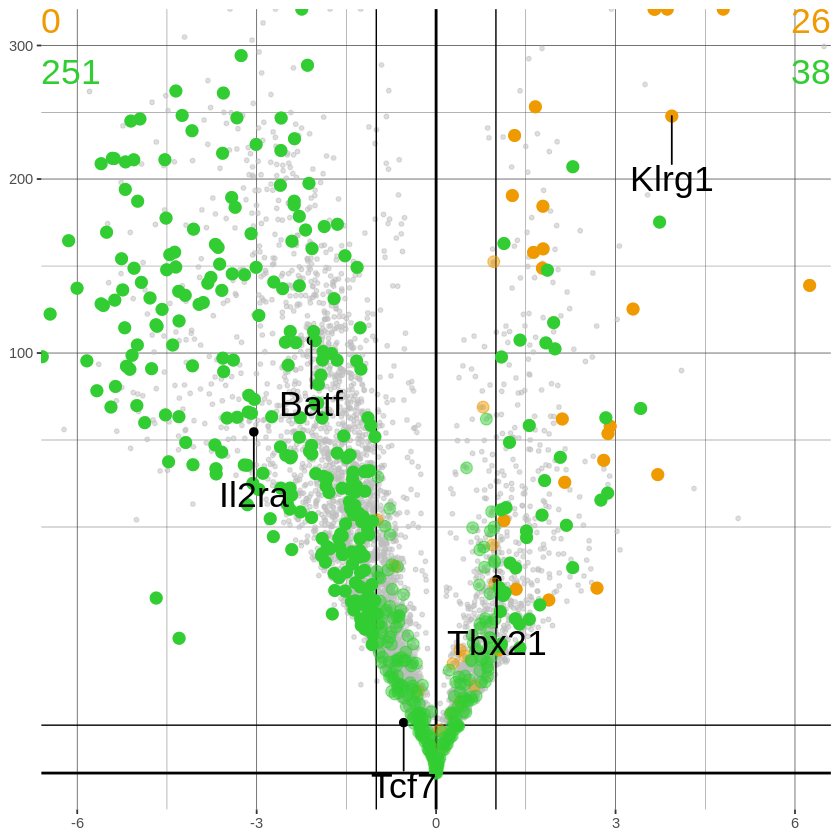

In [185]:
cp <- c("P10", "P2")
cp_oldnames <- cvt_names(cp, label.df$louvain_new_label, label.df$louvain)
cp_oldnames <- as.character(cp_oldnames)

###----- Setup
outname.base <- paste("All", cp[1], "vs", cp[2], sep="_")
use.genes <- c("Tbx21", "Il2ra", "Batf", "Tox", "Bach2", "Tcf7", "Tox","Batf3", "Klrg1", "Sell", "Cd127")
log2fc.c <- 1
nlog10p.c <- 1.3
gs.vec <- c("TE up", "TRM_vs_TCM-TEM")
gs.col.vec <- c("orange2", "limegreen")
log2fc.range <- c(-6,6)
nlog10pval.max <- 300


###----- Plot
# Read input
louvain.de.file <- paste(cp_oldnames[1], "vs", cp_oldnames[2], "differential.csv", sep="_")
louvain.de.file <- file.path(de.dir, file.path(cp_oldnames[1], louvain.de.file))
de.df <- read_csv(louvain.de.file)
# Filter out low expression & convert df for plotting
de.df <- de.df %>% 
  mutate(max_expr = pmax(pull(de.df, cp_oldnames[1]), pull(de.df, cp_oldnames[2]))) %>% filter(max_expr > 0.15) %>%
  drop_na() %>% select(one_of('gene_names', 't-test_logfc', 't-test_padj'))
colnames(de.df) <- c("gene_name", "log2fc", "padj")
de.df$nlog10pval <- -log10(de.df$padj)
# Plot 
vol_plot_out <- volcano_plot_highlightGSEA(de.df, use.genes, gs.vec, gs.col.vec, 
                                           log2fc.c, nlog10p.c,log2fc.range, nlog10pval.max) # With label
vol_plot <- vol_plot_out$plot
vol_plot
ggsave(paste(outname.base, ".png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')

# Save simplified plot
vol_plot <- vol_plot + theme(axis.text.x=element_blank(), axis.text.y=element_blank()) # Without label
ggsave(paste(outname.base, "_nolabel.png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')

# Save summary
write_csv(vol_plot_out$sum, paste(outname.base, "_sum.csv", sep=""))

Parsed with column specification:
cols(
  gene_names = col_character(),
  `5` = col_double(),
  `6` = col_double(),
  wilcoxon_logfc = col_double(),
  wilcoxon_padj = col_double(),
  wilcoxon_score = col_double(),
  `t-test_logfc` = col_double(),
  `t-test_padj` = col_double(),
  `t-test_score` = col_double(),
  `t-test_overestim_var_logfc` = col_double(),
  `t-test_overestim_var_padj` = col_double(),
  `t-test_overestim_var_score` = col_double()
)



  side TCM_vs_TEM-TRM TRM_vs_TCM-TEM
1   up              1             13
2   dn             22             52


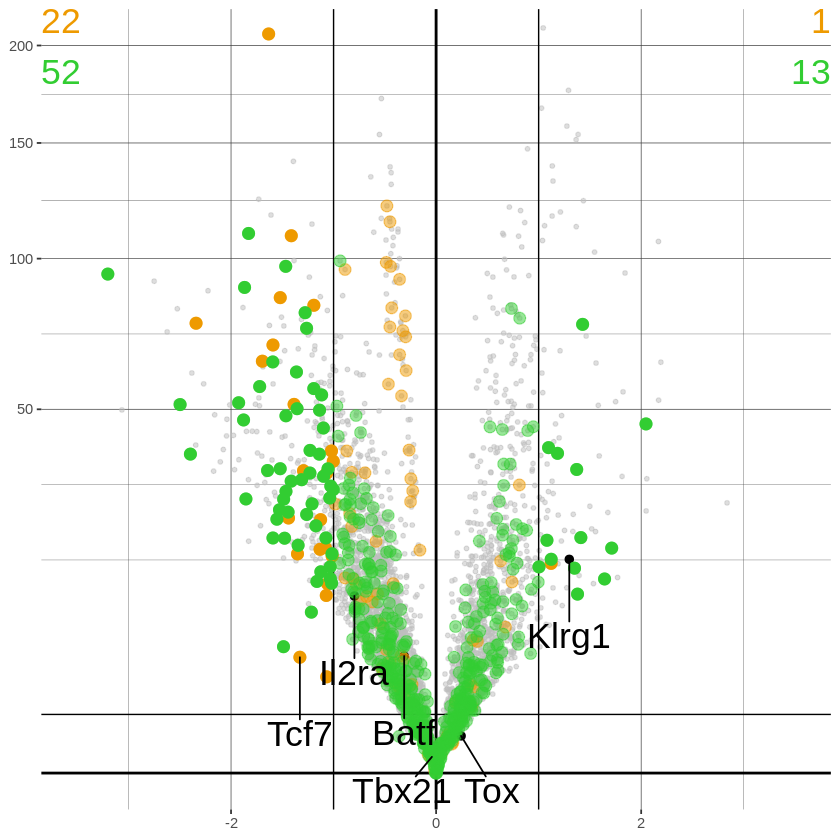

In [188]:
cp <- c("P6", "P2")
cp_oldnames <- cvt_names(cp, label.df$louvain_new_label, label.df$louvain)
cp_oldnames <- as.character(cp_oldnames)

###----- Setup
outname.base <- paste("All", cp[1], "vs", cp[2], sep="_")
use.genes <- c("Tbx21", "Il2ra", "Batf", "Tox", "Bach2", "Tcf7", "Tox","Batf3", "Klrg1", "Sell", "Cd127")
log2fc.c <- 1
nlog10p.c <- 1.3
gs.vec <- c("TCM_vs_TEM-TRM", "TRM_vs_TCM-TEM")
gs.col.vec <- c("orange2", "limegreen")
log2fc.range <- c(-3.5,3.5)
nlog10pval.max <- 200

###----- Plot
# Read input
louvain.de.file <- paste(cp_oldnames[1], "vs", cp_oldnames[2], "differential.csv", sep="_")
louvain.de.file <- file.path(de.dir, file.path(cp_oldnames[1], louvain.de.file))
de.df <- read_csv(louvain.de.file)
# Filter out low expression & convert df for plotting
de.df <- de.df %>% 
  mutate(max_expr = pmax(pull(de.df, cp_oldnames[1]), pull(de.df, cp_oldnames[2]))) %>% filter(max_expr > 0.15) %>%
  drop_na() %>% select(one_of('gene_names', 't-test_logfc', 't-test_padj'))
colnames(de.df) <- c("gene_name", "log2fc", "padj")
de.df$nlog10pval <- -log10(de.df$padj)
# Plot 
vol_plot_out <- volcano_plot_highlightGSEA(de.df, use.genes, gs.vec, gs.col.vec, 
                                           log2fc.c, nlog10p.c,log2fc.range, nlog10pval.max) # With label
vol_plot <- vol_plot_out$plot
vol_plot
ggsave(paste(outname.base, ".png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')

# Save simplified plot
vol_plot <- vol_plot + theme(axis.text.x=element_blank(), axis.text.y=element_blank()) # Without label
ggsave(paste(outname.base, "_nolabel.png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')

# Save summary
write_csv(vol_plot_out$sum, paste(outname.base, "_sum.csv", sep=""))

## 1. Arm / Cl13: cluster v.s. cluster

In [60]:
###----- Volcano plot - highlight GSEA
volcano_plot_highlightGSEA <- function(comp_df, h_genes, gs_vec, gs_col_vec,
                                       log2fc_c, nlog10p_c, log2fc_range=c(-6,6), nlog10pval_max=300) {
    ########## Parameters ##########
    # comp_df: differential output (gene_name, log2fc, padj, nlog10pval)
    # h_genes: genes to highlight (show text)
    # gs_vec: abbreviations of gene signature sets to use
    #     use get_gs_genes function to creat gs_genes_list:
    #     list("gs1"=("geneA", "geneB"), "gs2"=("geneC", "geneD"))
    # gs_col_vec: colors for gene signature sets
    # log2fc_c / nlog10p_c: log2fc cutoff for significance, -log10pvalue cutoff for significance
    # log2fc_range / nlog10pval_max: plotting range
    
    gsea_genes_list <- get_gs_genes(gs_vec)
    
    sig_nu_sum_df <- data.frame("side"=c("up", "dn")) # summary of sig. diff. gene # in GSEA
    
    #--- Assign categories for plotting
    volcano_df <- comp_df  %>% filter( ! gene_name %in% c("Xist", "Tsix", "Eif2s3y", "Ddx3y")) 
    h_df <- volcano_df %>% filter(gene_name %in% h_genes)
    
    #--- Plotting
    # All genes
    vol_gsea_plot <- ggplot(volcano_df, aes(x=log2fc, y=nlog10pval)) +
      geom_point(size=1, alpha=0.5, color="gray") +
      geom_vline(xintercept=0, size=0.8) +
      geom_hline(yintercept=0, size=0.8) +
      geom_vline(xintercept=-log2fc_c, size=0.4) +
      geom_vline(xintercept=log2fc_c, size=0.4) +
      geom_hline(yintercept=nlog10p_c, size=0.4) + 
      theme(plot.title = element_text(hjust = 0.5),
            panel.grid.major = element_line(color="gray25", size=0.2),
            panel.grid.minor = element_line(color="gray25", size=0.1),
            panel.background = element_rect(fill = 'white', colour = 'white'),
            axis.title.x = element_blank(),
            axis.title.y = element_blank()) +
      scale_y_sqrt() +
      coord_cartesian(xlim=log2fc_range, ylim=c(0, nlog10pval_max)) # will not remove dots that are out of scale
    # Genes to annotate
    vol_gsea_plot <- vol_gsea_plot +
      geom_point(data=h_df, size=2, alpha=1, color="black")
    # Add each GSEA set
    for (i in c(1:length(gs_vec))) {
        gs_i <- gs_vec[i]
        gsea_genes <- unlist(gsea_genes_list[gs_i])
        gsea_df <- volcano_df %>% filter(gene_name %in% gsea_genes)
        gsea_sig_df <- gsea_df %>% filter( abs(log2fc) >= log2fc_c ) %>% filter( nlog10pval >= nlog10p_c)
        gsea_sig_df_up <- gsea_sig_df %>% filter(log2fc > 0)
        gsea_sig_df_dn <- gsea_sig_df %>% filter(log2fc < 0)
        
        # Add in hightlight scatter plot
        vol_gsea_plot <- vol_gsea_plot + 
          geom_point(data=gsea_df, size=2, alpha=0.1, color=gs_col_vec[i])
        vol_gsea_plot <- vol_gsea_plot +
          geom_point(data=gsea_sig_df, size=2, alpha=6, color=gs_col_vec[i])
        
        # Add in summary
        gs_i_sum_nu <- c(nrow(gsea_sig_df_up), nrow(gsea_sig_df_dn))
        sig_nu_sum_df[gs_i] <- gs_i_sum_nu
        
        # Create text annotations
        padding <- paste(rep("\n",i-1), collapse="")
        text_with_padding <- paste(padding, as.character(gs_i_sum_nu), sep="")
        annotations <- data.frame(xpos = c(Inf,-Inf), 
                                  ypos =  c(Inf,Inf),
                                  annotateText = text_with_padding,
                                  hjustvar = c(1,0),
                                  vjustvar = c(1,1))
        vol_gsea_plot <- vol_gsea_plot +
          geom_text(data=annotations,aes(x=xpos,y=ypos,hjust=hjustvar,vjust=vjustvar,
                                         label=annotateText), size=7.5, color=gs_col_vec[i])
        
    }
    
    print(sig_nu_sum_df)
    # Gene name text anno
    vol_gsea_plot <- vol_gsea_plot + 
      geom_text_repel(data=h_df, size=7.5, nudge_y=-nlog10pval_max/200, 
                      aes(x=log2fc, y=nlog10pval, label=gene_name))
    return(list("plot"=vol_gsea_plot, "sum"=sig_nu_sum_df))
}

In [19]:
arm.de.dir <- '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/1_Scanpy/1_Scanpy_out_resampled_ARM-NAV/2_DE/Cluster_vs_Cluster'
cl13.de.dir <- '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/1_Scanpy/1_Scanpy_out_resampled_Cl13-NAV/2_DE/Cluster_vs_Cluster'

---
## P2 v.s. P0

In [61]:
cp <- c("P2", "P0")
cp_oldnames <- cvt_names(cp, label.df$louvain_new_label, label.df$louvain)
cp_oldnames <- as.character(cp_oldnames)

###----- Setup
use.genes <- c("Tbx21", "Il2ra", "Batf", "Tox", "Bach2", "Tcf7", "Tox","Batf3", "Klrg1", "Sell", "Cd127")
log2fc.c <- 1
nlog10p.c <- 1.3
gs.vec <- c("TE up", "TCM_vs_TEM-TRM")
gs.col.vec <- c("orange2", "limegreen")

*Arm*

Parsed with column specification:
cols(
  gene_names = col_character(),
  `3` = col_double(),
  `6` = col_double(),
  wilcoxon_logfc = col_double(),
  wilcoxon_padj = col_double(),
  wilcoxon_score = col_double(),
  `t-test_logfc` = col_double(),
  `t-test_padj` = col_double(),
  `t-test_score` = col_double(),
  `t-test_overestim_var_logfc` = col_double(),
  `t-test_overestim_var_padj` = col_double(),
  `t-test_overestim_var_score` = col_double()
)



  side TE up TCM_vs_TEM-TRM
1   up    17             24
2   dn     2             31


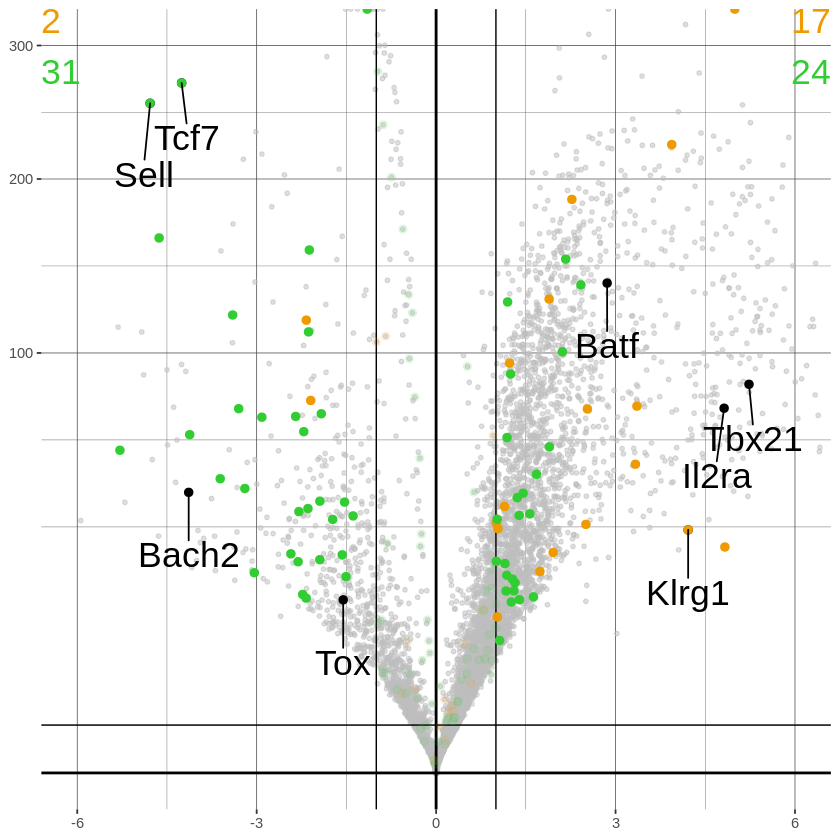

In [62]:
###----- Cell type specific setup
cell.type <- "Arm"
de.dir <- arm.de.dir
outname.base <- paste(cell.type, cp[1], "vs", cp[2], sep="_")
log2fc.range <- c(-6,6)
nlog10pval.max <- 300

###----- Plot
#--- Read input
louvain.de.file <- paste(cp_oldnames[1], "vs", cp_oldnames[2], "differential.csv", sep="_")
louvain.de.file <- file.path(de.dir, file.path(cp_oldnames[1], louvain.de.file))
de.df <- read_csv(louvain.de.file)
# Filter out low expression & convert df for plotting
de.df <- de.df %>% 
  mutate(max_expr = pmax(pull(de.df, cp_oldnames[1]), pull(de.df, cp_oldnames[2]))) %>% 
  filter(max_expr > 0.15) %>%
  drop_na() %>% select(one_of('gene_names', 't-test_logfc', 't-test_padj'))
colnames(de.df) <- c("gene_name", "log2fc", "padj")
de.df$nlog10pval <- -log10(de.df$padj)

#--- Plot
vol_plot_out <- volcano_plot_highlightGSEA(de.df, use.genes, gs.vec, gs.col.vec, 
                                           log2fc.c, nlog10p.c,log2fc.range, nlog10pval.max) # With label
vol_plot <- vol_plot_out$plot
# Show plot
vol_plot
# Save plot
ggsave(paste(outname.base, ".png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')
# Save simplified plot
vol_plot <- vol_plot + theme(axis.text.x=element_blank(), axis.text.y=element_blank()) # Without label
ggsave(paste(outname.base, "_nolabel.png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')
# Save summary
write_csv(vol_plot_out$sum, paste(outname.base, "_sum.csv", sep=""))

*Cl13*

Parsed with column specification:
cols(
  gene_names = col_character(),
  `3` = col_double(),
  `6` = col_double(),
  wilcoxon_logfc = col_double(),
  wilcoxon_padj = col_double(),
  wilcoxon_score = col_double(),
  `t-test_logfc` = col_double(),
  `t-test_padj` = col_double(),
  `t-test_score` = col_double(),
  `t-test_overestim_var_logfc` = col_double(),
  `t-test_overestim_var_padj` = col_double(),
  `t-test_overestim_var_score` = col_double()
)



  side TE up TCM_vs_TEM-TRM
1   up    12             25
2   dn     3             30


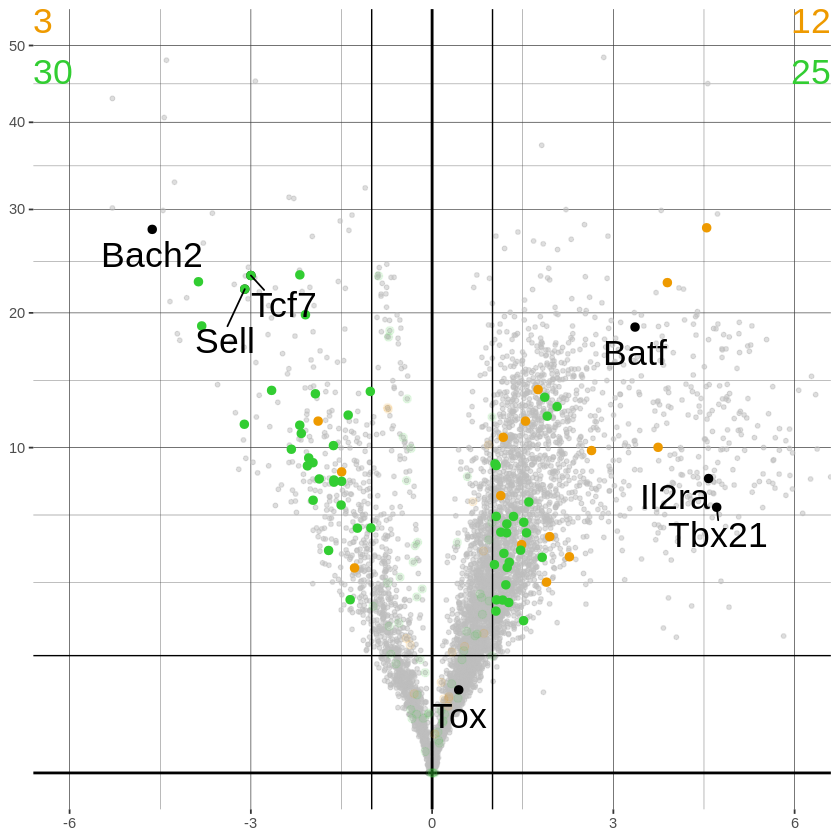

In [63]:
###----- Cell type specific setup
cell.type <- "Cl13"
de.dir <- cl13.de.dir
outname.base <- paste(cell.type, cp[1], "vs", cp[2], sep="_")
log2fc.range <- c(-6,6)
nlog10pval.max <- 50

###----- Plot
#--- Read input
louvain.de.file <- paste(cp_oldnames[1], "vs", cp_oldnames[2], "differential.csv", sep="_")
louvain.de.file <- file.path(de.dir, file.path(cp_oldnames[1], louvain.de.file))
de.df <- read_csv(louvain.de.file)
# Filter out low expression & convert df for plotting
de.df <- de.df %>% 
  mutate(max_expr = pmax(pull(de.df, cp_oldnames[1]), pull(de.df, cp_oldnames[2]))) %>% 
  filter(max_expr > 0.15) %>%
  drop_na() %>% select(one_of('gene_names', 't-test_logfc', 't-test_padj'))
colnames(de.df) <- c("gene_name", "log2fc", "padj")
de.df$nlog10pval <- -log10(de.df$padj)

#--- Plot
vol_plot_out <- volcano_plot_highlightGSEA(de.df, use.genes, gs.vec, gs.col.vec, 
                                           log2fc.c, nlog10p.c,log2fc.range, nlog10pval.max) # With label
vol_plot <- vol_plot_out$plot
# Show plot
vol_plot
# Save plot
ggsave(paste(outname.base, ".png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')
# Save simplified plot
vol_plot <- vol_plot + theme(axis.text.x=element_blank(), axis.text.y=element_blank()) # Without label
ggsave(paste(outname.base, "_nolabel.png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')
# Save summary
write_csv(vol_plot_out$sum, paste(outname.base, "_sum.csv", sep=""))

In [50]:
get_gs_genes()

[1] "Possible signatures for using:"
 [1] "48h Act up"     "DP up"          "EE up"          "Tex dn"        
 [5] "Tex up"         "JJM_Tcm"        "JJM_Trm"        "Rao_MEM"       
 [9] "MP up"          "Naive up"       "TE up"          "Tex_int down"  
[13] "Tex_int up"     "Tex prog1 down" "Tex prog1 up"   "Tex prog2 down"
[17] "Tex prog2 up"   "Tex_term dn"    "Tex_term up"    "Tstem"         
[21] "Best_1"         "Best_10"        "Best_2"         "Best_3"        
[25] "Best_4"         "Best_5"         "Best_6"         "Best_7"        
[29] "Best_8"         "Best_9"         "Day5KLRG1hi up" "TRM_vs_TCM-TEM"
[33] "TCM_vs_TEM-TRM" "Day5KLRG1lo up" "TEM_vs_TCM-TRM"


---
## P6 v.s. P2

In [76]:
cp <- c("P6", "P2")
cp_oldnames <- cvt_names(cp, label.df$louvain_new_label, label.df$louvain)
cp_oldnames <- as.character(cp_oldnames)

###----- Setup
use.genes <- c("Tbx21", "Il2ra", "Batf", "Tox", "Bach2", "Tcf7", "Tox","Batf3", "Klrg1", "Sell", "Cd127")
log2fc.c <- 1
nlog10p.c <- 1.3
gs.vec <- c( "EE up")
gs.col.vec <- c("orange2")

*Arm*

Parsed with column specification:
cols(
  gene_names = col_character(),
  `5` = col_double(),
  `6` = col_double(),
  wilcoxon_logfc = col_double(),
  wilcoxon_padj = col_double(),
  wilcoxon_score = col_double(),
  `t-test_logfc` = col_double(),
  `t-test_padj` = col_double(),
  `t-test_score` = col_double(),
  `t-test_overestim_var_logfc` = col_double(),
  `t-test_overestim_var_padj` = col_double(),
  `t-test_overestim_var_score` = col_double()
)



  side EE up
1   up     4
2   dn     0


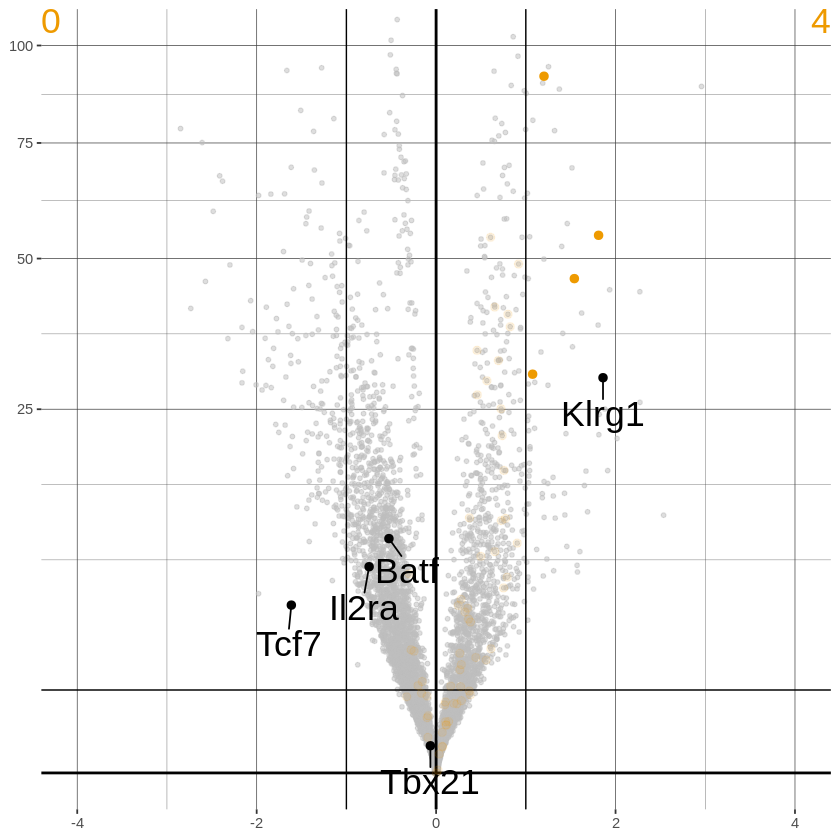

In [77]:
###----- Cell type specific setup
cell.type <- "Arm"
de.dir <- arm.de.dir
outname.base <- paste(cell.type, cp[1], "vs", cp[2], sep="_")
log2fc.range <- c(-4,4)
nlog10pval.max <- 100

###----- Plot
#--- Read input
louvain.de.file <- paste(cp_oldnames[1], "vs", cp_oldnames[2], "differential.csv", sep="_")
louvain.de.file <- file.path(de.dir, file.path(cp_oldnames[1], louvain.de.file))
de.df <- read_csv(louvain.de.file)
# Filter out low expression & convert df for plotting
de.df <- de.df %>% 
  mutate(max_expr = pmax(pull(de.df, cp_oldnames[1]), pull(de.df, cp_oldnames[2]))) %>% 
  filter(max_expr > 0.15) %>%
  drop_na() %>% select(one_of('gene_names', 't-test_logfc', 't-test_padj'))
colnames(de.df) <- c("gene_name", "log2fc", "padj")
de.df$nlog10pval <- -log10(de.df$padj)

#--- Plot
vol_plot_out <- volcano_plot_highlightGSEA(de.df, use.genes, gs.vec, gs.col.vec, 
                                           log2fc.c, nlog10p.c,log2fc.range, nlog10pval.max) # With label
vol_plot <- vol_plot_out$plot
# Show plot
vol_plot
# Save plot
ggsave(paste(outname.base, ".png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')
# Save simplified plot
vol_plot <- vol_plot + theme(axis.text.x=element_blank(), axis.text.y=element_blank()) # Without label
ggsave(paste(outname.base, "_nolabel.png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')
# Save summary
write_csv(vol_plot_out$sum, paste(outname.base, "_sum.csv", sep=""))

*Cl13*

Parsed with column specification:
cols(
  gene_names = col_character(),
  `5` = col_double(),
  `6` = col_double(),
  wilcoxon_logfc = col_double(),
  wilcoxon_padj = col_double(),
  wilcoxon_score = col_double(),
  `t-test_logfc` = col_double(),
  `t-test_padj` = col_double(),
  `t-test_score` = col_double(),
  `t-test_overestim_var_logfc` = col_double(),
  `t-test_overestim_var_padj` = col_double(),
  `t-test_overestim_var_score` = col_double()
)



  side EE up
1   up    10
2   dn     0


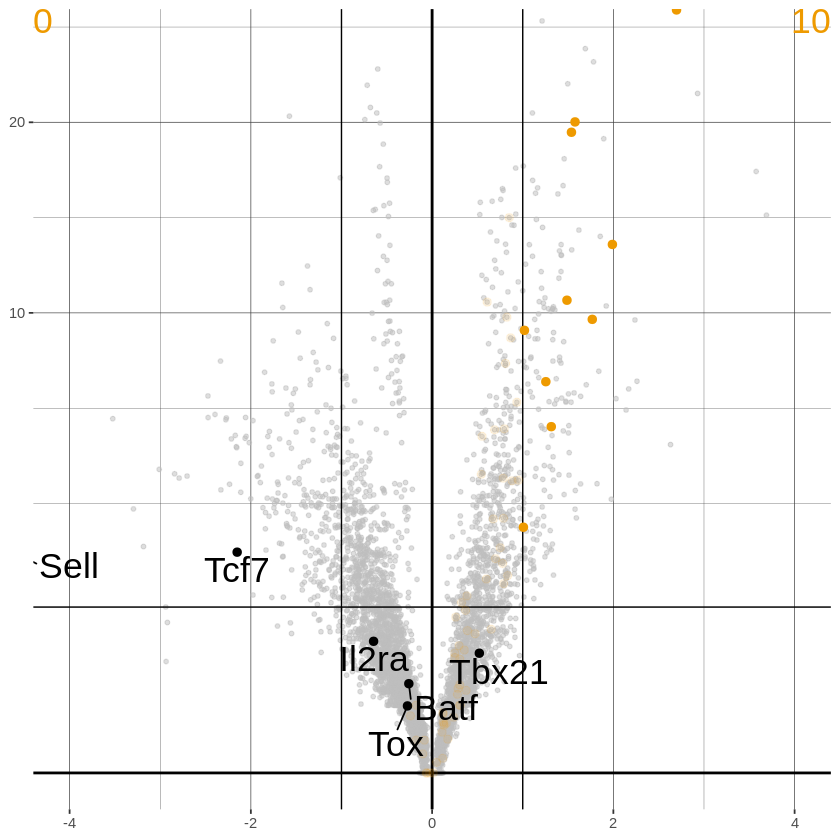

In [78]:
###----- Cell type specific setup
cell.type <- "Cl13"
de.dir <- cl13.de.dir
outname.base <- paste(cell.type, cp[1], "vs", cp[2], sep="_")
log2fc.range <- c(-4,4)
nlog10pval.max <- 25

###----- Plot
#--- Read input
louvain.de.file <- paste(cp_oldnames[1], "vs", cp_oldnames[2], "differential.csv", sep="_")
louvain.de.file <- file.path(de.dir, file.path(cp_oldnames[1], louvain.de.file))
de.df <- read_csv(louvain.de.file)
# Filter out low expression & convert df for plotting
de.df <- de.df %>% 
  mutate(max_expr = pmax(pull(de.df, cp_oldnames[1]), pull(de.df, cp_oldnames[2]))) %>% 
  filter(max_expr > 0.15) %>%
  drop_na() %>% select(one_of('gene_names', 't-test_logfc', 't-test_padj'))
colnames(de.df) <- c("gene_name", "log2fc", "padj")
de.df$nlog10pval <- -log10(de.df$padj)

#--- Plot
vol_plot_out <- volcano_plot_highlightGSEA(de.df, use.genes, gs.vec, gs.col.vec, 
                                           log2fc.c, nlog10p.c,log2fc.range, nlog10pval.max) # With label
vol_plot <- vol_plot_out$plot
# Show plot
vol_plot
# Save plot
ggsave(paste(outname.base, ".png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')
# Save simplified plot
vol_plot <- vol_plot + theme(axis.text.x=element_blank(), axis.text.y=element_blank()) # Without label
ggsave(paste(outname.base, "_nolabel.png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')
# Save summary
write_csv(vol_plot_out$sum, paste(outname.base, "_sum.csv", sep=""))

---
## P7 v.s. P2

In [67]:
cp <- c("P7", "P2")
cp_oldnames <- cvt_names(cp, label.df$louvain_new_label, label.df$louvain)
cp_oldnames <- as.character(cp_oldnames)

###----- Setup
use.genes <- c("Tbx21", "Il2ra", "Batf", "Tox", "Bach2", "Tcf7", "Tox","Batf3", "Klrg1", "Sell", "Cd127")
log2fc.c <- 1
nlog10p.c <- 1.3
gs.vec <- c( "Tstem")
gs.col.vec <- c("orange2")

*Arm*

Parsed with column specification:
cols(
  gene_names = col_character(),
  `6` = col_double(),
  `7` = col_double(),
  wilcoxon_logfc = col_double(),
  wilcoxon_padj = col_double(),
  wilcoxon_score = col_double(),
  `t-test_logfc` = col_double(),
  `t-test_padj` = col_double(),
  `t-test_score` = col_double(),
  `t-test_overestim_var_logfc` = col_double(),
  `t-test_overestim_var_padj` = col_double(),
  `t-test_overestim_var_score` = col_double()
)



  side Tstem
1   up    53
2   dn     0


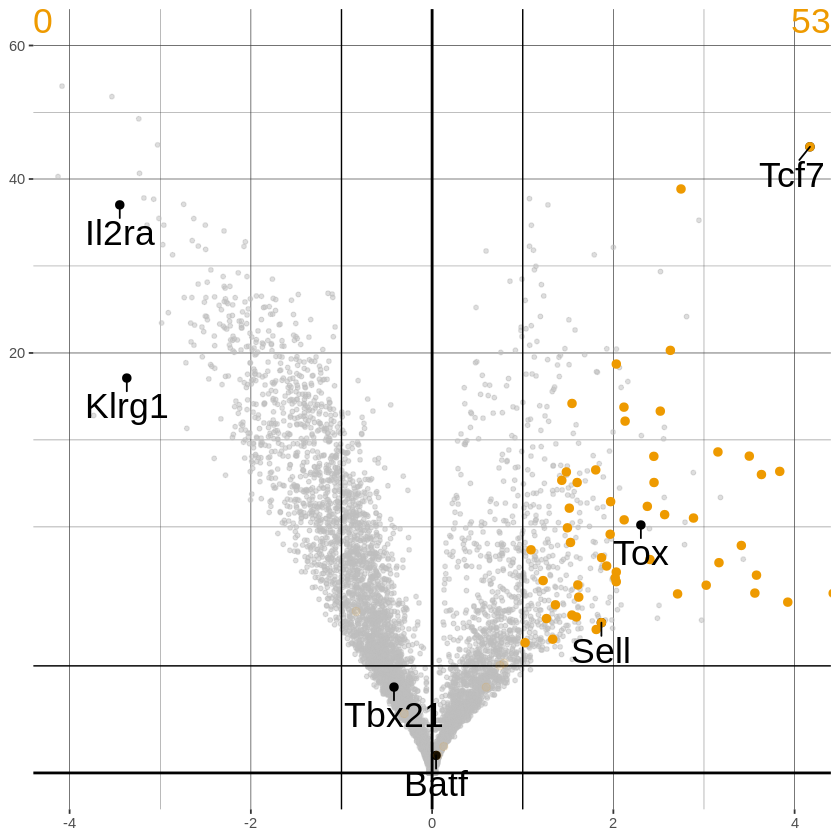

In [70]:
###----- Cell type specific setup
cell.type <- "Arm"
de.dir <- arm.de.dir
outname.base <- paste(cell.type, cp[1], "vs", cp[2], sep="_")
log2fc.range <- c(-4,4)
nlog10pval.max <- 60

###----- Plot
#--- Read input
louvain.de.file <- paste(cp_oldnames[1], "vs", cp_oldnames[2], "differential.csv", sep="_")
louvain.de.file <- file.path(de.dir, file.path(cp_oldnames[1], louvain.de.file))
de.df <- read_csv(louvain.de.file)
# Filter out low expression & convert df for plotting
de.df <- de.df %>% 
  mutate(max_expr = pmax(pull(de.df, cp_oldnames[1]), pull(de.df, cp_oldnames[2]))) %>% 
  filter(max_expr > 0.15) %>%
  drop_na() %>% select(one_of('gene_names', 't-test_logfc', 't-test_padj'))
colnames(de.df) <- c("gene_name", "log2fc", "padj")
de.df$nlog10pval <- -log10(de.df$padj)

#--- Plot
vol_plot_out <- volcano_plot_highlightGSEA(de.df, use.genes, gs.vec, gs.col.vec, 
                                           log2fc.c, nlog10p.c,log2fc.range, nlog10pval.max) # With label
vol_plot <- vol_plot_out$plot
# Show plot
vol_plot
# Save plot
ggsave(paste(outname.base, ".png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')
# Save simplified plot
vol_plot <- vol_plot + theme(axis.text.x=element_blank(), axis.text.y=element_blank()) # Without label
ggsave(paste(outname.base, "_nolabel.png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')
# Save summary
write_csv(vol_plot_out$sum, paste(outname.base, "_sum.csv", sep=""))

*Cl13*

Parsed with column specification:
cols(
  gene_names = col_character(),
  `6` = col_double(),
  `7` = col_double(),
  wilcoxon_logfc = col_double(),
  wilcoxon_padj = col_double(),
  wilcoxon_score = col_double(),
  `t-test_logfc` = col_double(),
  `t-test_padj` = col_double(),
  `t-test_score` = col_double(),
  `t-test_overestim_var_logfc` = col_double(),
  `t-test_overestim_var_padj` = col_double(),
  `t-test_overestim_var_score` = col_double()
)



  side Tstem
1   up    40
2   dn     0


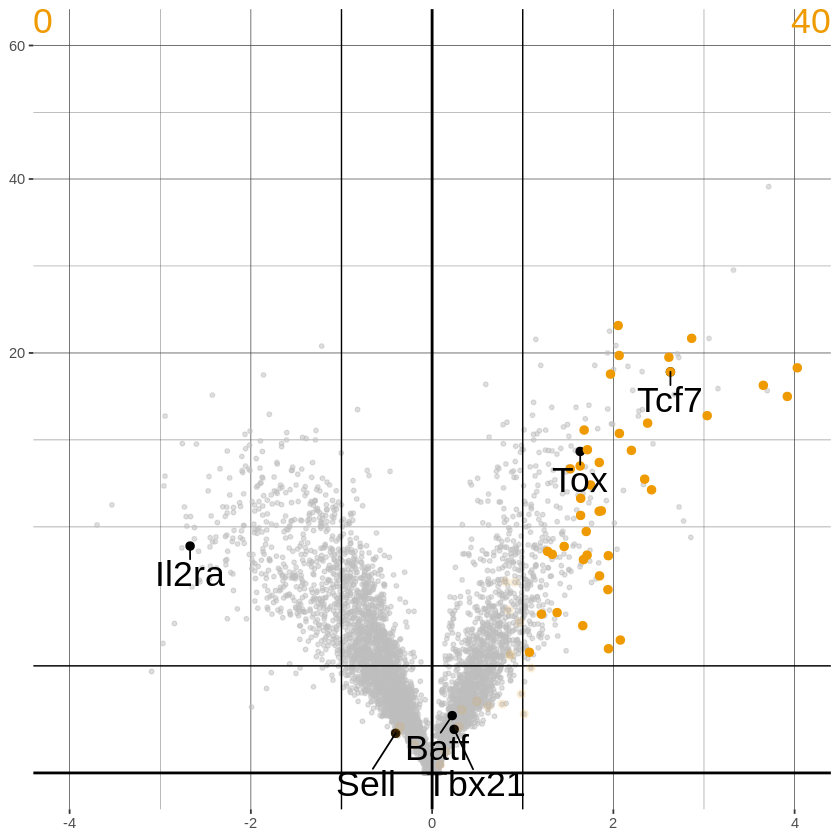

In [71]:
###----- Cell type specific setup
cell.type <- "Cl13"
de.dir <- cl13.de.dir
outname.base <- paste(cell.type, cp[1], "vs", cp[2], sep="_")
log2fc.range <- c(-4,4)
nlog10pval.max <- 60

###----- Plot
#--- Read input
louvain.de.file <- paste(cp_oldnames[1], "vs", cp_oldnames[2], "differential.csv", sep="_")
louvain.de.file <- file.path(de.dir, file.path(cp_oldnames[1], louvain.de.file))
de.df <- read_csv(louvain.de.file)
# Filter out low expression & convert df for plotting
de.df <- de.df %>% 
  mutate(max_expr = pmax(pull(de.df, cp_oldnames[1]), pull(de.df, cp_oldnames[2]))) %>% 
  filter(max_expr > 0.15) %>%
  drop_na() %>% select(one_of('gene_names', 't-test_logfc', 't-test_padj'))
colnames(de.df) <- c("gene_name", "log2fc", "padj")
de.df$nlog10pval <- -log10(de.df$padj)

#--- Plot
vol_plot_out <- volcano_plot_highlightGSEA(de.df, use.genes, gs.vec, gs.col.vec, 
                                           log2fc.c, nlog10p.c,log2fc.range, nlog10pval.max) # With label
vol_plot <- vol_plot_out$plot
# Show plot
vol_plot
# Save plot
ggsave(paste(outname.base, ".png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')
# Save simplified plot
vol_plot <- vol_plot + theme(axis.text.x=element_blank(), axis.text.y=element_blank()) # Without label
ggsave(paste(outname.base, "_nolabel.png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')
# Save summary
write_csv(vol_plot_out$sum, paste(outname.base, "_sum.csv", sep=""))

---
## P3 v.s. P2

In [90]:
cp <- c("P3", "P2")
cp_oldnames <- cvt_names(cp, label.df$louvain_new_label, label.df$louvain)
cp_oldnames <- as.character(cp_oldnames)

###----- Setup
use.genes <- c("Tbx21", "Il2ra", "Batf", "Tox", "Bach2", "Tcf7", "Tox","Batf3", "Klrg1", "Sell", "Cd127")
log2fc.c <- 1
nlog10p.c <- 1.3
gs.vec <- c( "DP up", "TEM_vs_TCM-TRM")
gs.col.vec <- c("orange2", "limegreen")

*Arm*

Parsed with column specification:
cols(
  gene_names = col_character(),
  `1` = col_double(),
  `6` = col_double(),
  wilcoxon_logfc = col_double(),
  wilcoxon_padj = col_double(),
  wilcoxon_score = col_double(),
  `t-test_logfc` = col_double(),
  `t-test_padj` = col_double(),
  `t-test_score` = col_double(),
  `t-test_overestim_var_logfc` = col_double(),
  `t-test_overestim_var_padj` = col_double(),
  `t-test_overestim_var_score` = col_double()
)



  side DP up TEM_vs_TCM-TRM
1   up    35             15
2   dn     1              0


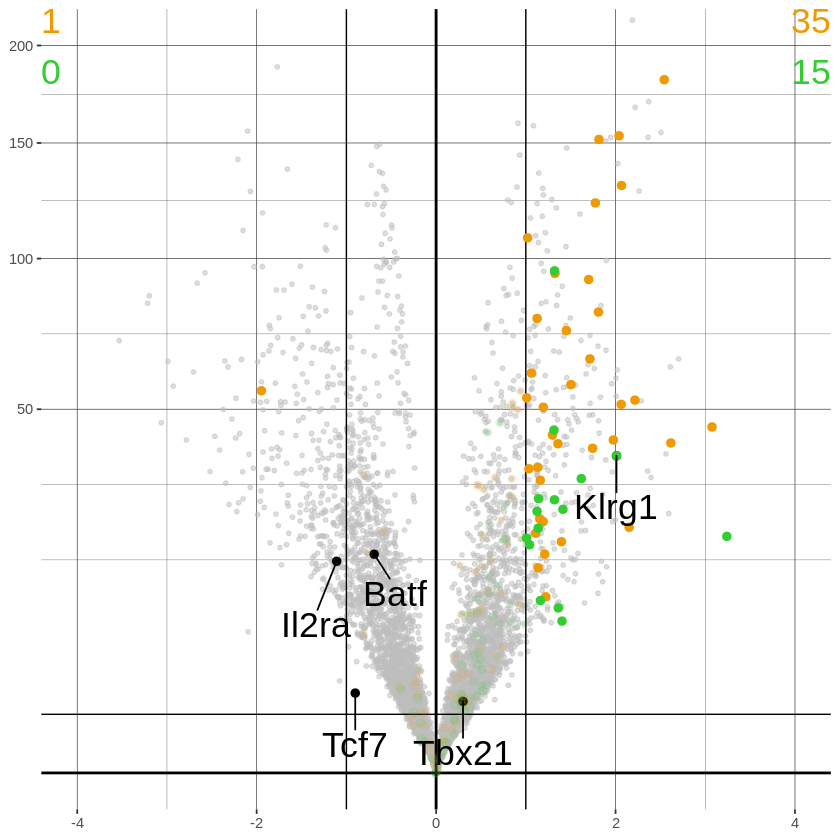

In [95]:
###----- Cell type specific setup
cell.type <- "Arm"
de.dir <- arm.de.dir
outname.base <- paste(cell.type, cp[1], "vs", cp[2], sep="_")
log2fc.range <- c(-4,4)
nlog10pval.max <- 200

###----- Plot
#--- Read input
louvain.de.file <- paste(cp_oldnames[1], "vs", cp_oldnames[2], "differential.csv", sep="_")
louvain.de.file <- file.path(de.dir, file.path(cp_oldnames[1], louvain.de.file))
de.df <- read_csv(louvain.de.file)
# Filter out low expression & convert df for plotting
de.df <- de.df %>% 
  mutate(max_expr = pmax(pull(de.df, cp_oldnames[1]), pull(de.df, cp_oldnames[2]))) %>% 
  filter(max_expr > 0.15) %>%
  drop_na() %>% select(one_of('gene_names', 't-test_logfc', 't-test_padj'))
colnames(de.df) <- c("gene_name", "log2fc", "padj")
de.df$nlog10pval <- -log10(de.df$padj)

#--- Plot
vol_plot_out <- volcano_plot_highlightGSEA(de.df, use.genes, gs.vec, gs.col.vec, 
                                           log2fc.c, nlog10p.c,log2fc.range, nlog10pval.max) # With label
vol_plot <- vol_plot_out$plot
# Show plot
vol_plot
# Save plot
ggsave(paste(outname.base, ".png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')
# Save simplified plot
vol_plot <- vol_plot + theme(axis.text.x=element_blank(), axis.text.y=element_blank()) # Without label
ggsave(paste(outname.base, "_nolabel.png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')
# Save summary
write_csv(vol_plot_out$sum, paste(outname.base, "_sum.csv", sep=""))

*Cl13*

Parsed with column specification:
cols(
  gene_names = col_character(),
  `1` = col_double(),
  `6` = col_double(),
  wilcoxon_logfc = col_double(),
  wilcoxon_padj = col_double(),
  wilcoxon_score = col_double(),
  `t-test_logfc` = col_double(),
  `t-test_padj` = col_double(),
  `t-test_score` = col_double(),
  `t-test_overestim_var_logfc` = col_double(),
  `t-test_overestim_var_padj` = col_double(),
  `t-test_overestim_var_score` = col_double()
)



  side DP up TEM_vs_TCM-TRM
1   up    49              9
2   dn     1              0


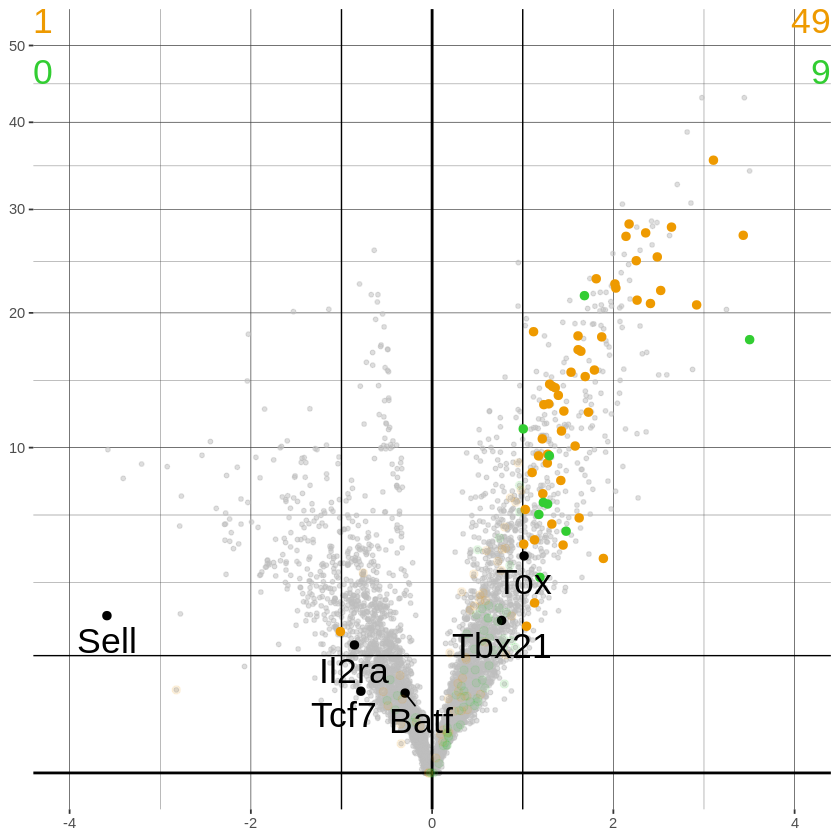

In [97]:
###----- Cell type specific setup
cell.type <- "Cl13"
de.dir <- cl13.de.dir
outname.base <- paste(cell.type, cp[1], "vs", cp[2], sep="_")
log2fc.range <- c(-4,4)
nlog10pval.max <- 50

###----- Plot
#--- Read input
louvain.de.file <- paste(cp_oldnames[1], "vs", cp_oldnames[2], "differential.csv", sep="_")
louvain.de.file <- file.path(de.dir, file.path(cp_oldnames[1], louvain.de.file))
de.df <- read_csv(louvain.de.file)
# Filter out low expression & convert df for plotting
de.df <- de.df %>% 
  mutate(max_expr = pmax(pull(de.df, cp_oldnames[1]), pull(de.df, cp_oldnames[2]))) %>% 
  filter(max_expr > 0.15) %>%
  drop_na() %>% select(one_of('gene_names', 't-test_logfc', 't-test_padj'))
colnames(de.df) <- c("gene_name", "log2fc", "padj")
de.df$nlog10pval <- -log10(de.df$padj)

#--- Plot
vol_plot_out <- volcano_plot_highlightGSEA(de.df, use.genes, gs.vec, gs.col.vec, 
                                           log2fc.c, nlog10p.c,log2fc.range, nlog10pval.max) # With label
vol_plot <- vol_plot_out$plot
# Show plot
vol_plot
# Save plot
ggsave(paste(outname.base, ".png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')
# Save simplified plot
vol_plot <- vol_plot + theme(axis.text.x=element_blank(), axis.text.y=element_blank()) # Without label
ggsave(paste(outname.base, "_nolabel.png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')
# Save summary
write_csv(vol_plot_out$sum, paste(outname.base, "_sum.csv", sep=""))

---
## P10 v.s. P2

In [100]:
cp <- c("P10", "P2")
cp_oldnames <- cvt_names(cp, label.df$louvain_new_label, label.df$louvain)
cp_oldnames <- as.character(cp_oldnames)

###----- Setup
use.genes <- c("Tbx21", "Il2ra", "Batf", "Tox", "Bach2", "Tcf7", "Tox","Batf3", "Klrg1", "Sell", "Cd127")
log2fc.c <- 1
nlog10p.c <- 1.3
gs.vec <- c( "TE up", "EE up")
gs.col.vec <- c("orange2", "limegreen")

*Arm*

Parsed with column specification:
cols(
  gene_names = col_character(),
  `2` = col_double(),
  `6` = col_double(),
  wilcoxon_logfc = col_double(),
  wilcoxon_padj = col_double(),
  wilcoxon_score = col_double(),
  `t-test_logfc` = col_double(),
  `t-test_padj` = col_double(),
  `t-test_score` = col_double(),
  `t-test_overestim_var_logfc` = col_double(),
  `t-test_overestim_var_padj` = col_double(),
  `t-test_overestim_var_score` = col_double()
)



  side TE up EE up
1   up    26     6
2   dn     0    13


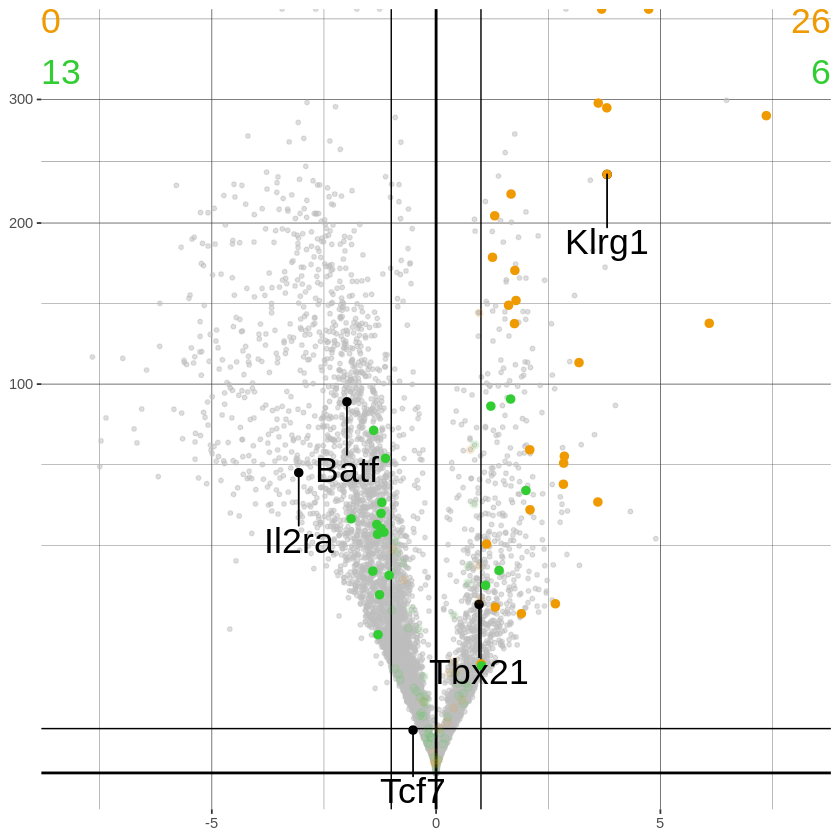

In [102]:
###----- Cell type specific setup
cell.type <- "Arm"
de.dir <- arm.de.dir
outname.base <- paste(cell.type, cp[1], "vs", cp[2], sep="_")
log2fc.range <- c(-8,8)
nlog10pval.max <- 350

###----- Plot
#--- Read input
louvain.de.file <- paste(cp_oldnames[1], "vs", cp_oldnames[2], "differential.csv", sep="_")
louvain.de.file <- file.path(de.dir, file.path(cp_oldnames[1], louvain.de.file))
de.df <- read_csv(louvain.de.file)
# Filter out low expression & convert df for plotting
de.df <- de.df %>% 
  mutate(max_expr = pmax(pull(de.df, cp_oldnames[1]), pull(de.df, cp_oldnames[2]))) %>% 
  filter(max_expr > 0.15) %>%
  drop_na() %>% select(one_of('gene_names', 't-test_logfc', 't-test_padj'))
colnames(de.df) <- c("gene_name", "log2fc", "padj")
de.df$nlog10pval <- -log10(de.df$padj)

#--- Plot
vol_plot_out <- volcano_plot_highlightGSEA(de.df, use.genes, gs.vec, gs.col.vec, 
                                           log2fc.c, nlog10p.c,log2fc.range, nlog10pval.max) # With label
vol_plot <- vol_plot_out$plot
# Show plot
vol_plot
# Save plot
ggsave(paste(outname.base, ".png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')
# Save simplified plot
vol_plot <- vol_plot + theme(axis.text.x=element_blank(), axis.text.y=element_blank()) # Without label
ggsave(paste(outname.base, "_nolabel.png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')
# Save summary
write_csv(vol_plot_out$sum, paste(outname.base, "_sum.csv", sep=""))

*Cl13*

Parsed with column specification:
cols(
  gene_names = col_character(),
  `2` = col_double(),
  `6` = col_double(),
  wilcoxon_logfc = col_double(),
  wilcoxon_padj = col_double(),
  wilcoxon_score = col_double(),
  `t-test_logfc` = col_double(),
  `t-test_padj` = col_double(),
  `t-test_score` = col_double(),
  `t-test_overestim_var_logfc` = col_double(),
  `t-test_overestim_var_padj` = col_double(),
  `t-test_overestim_var_score` = col_double()
)



  side TE up EE up
1   up     5     1
2   dn     4    18


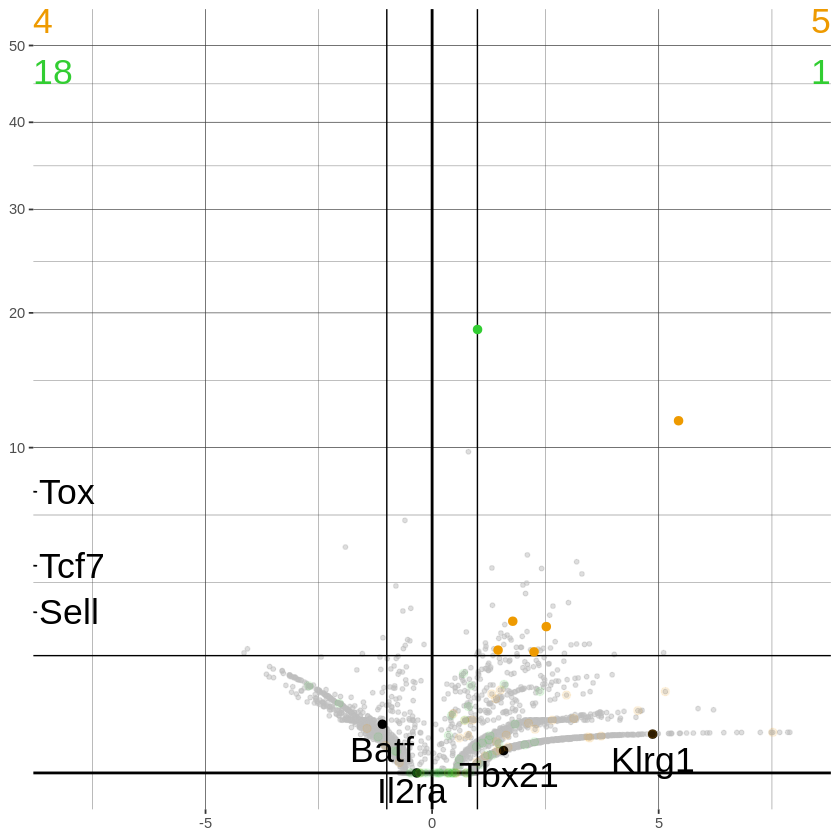

In [104]:
###----- Cell type specific setup
cell.type <- "Cl13"
de.dir <- cl13.de.dir
outname.base <- paste(cell.type, cp[1], "vs", cp[2], sep="_")
log2fc.range <- c(-8,8)
nlog10pval.max <- 50

###----- Plot
#--- Read input
louvain.de.file <- paste(cp_oldnames[1], "vs", cp_oldnames[2], "differential.csv", sep="_")
louvain.de.file <- file.path(de.dir, file.path(cp_oldnames[1], louvain.de.file))
de.df <- read_csv(louvain.de.file)
# Filter out low expression & convert df for plotting
de.df <- de.df %>% 
  mutate(max_expr = pmax(pull(de.df, cp_oldnames[1]), pull(de.df, cp_oldnames[2]))) %>% 
  filter(max_expr > 0.15) %>%
  drop_na() %>% select(one_of('gene_names', 't-test_logfc', 't-test_padj'))
colnames(de.df) <- c("gene_name", "log2fc", "padj")
de.df$nlog10pval <- -log10(de.df$padj)

#--- Plot
vol_plot_out <- volcano_plot_highlightGSEA(de.df, use.genes, gs.vec, gs.col.vec, 
                                           log2fc.c, nlog10p.c,log2fc.range, nlog10pval.max) # With label
vol_plot <- vol_plot_out$plot
# Show plot
vol_plot
# Save plot
ggsave(paste(outname.base, ".png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')
# Save simplified plot
vol_plot <- vol_plot + theme(axis.text.x=element_blank(), axis.text.y=element_blank()) # Without label
ggsave(paste(outname.base, "_nolabel.png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')
# Save summary
write_csv(vol_plot_out$sum, paste(outname.base, "_sum.csv", sep=""))

## 2. In cluster: Arm v.s. Cl13

In [105]:
de.dir <- '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/1_Scanpy/0_Scanpy_out_resampled/2_DE/perCluster_Arm_vs_Cl13'

Parsed with column specification:
cols(
  gene_names = col_character(),
  A = col_double(),
  C = col_double(),
  wilcoxon_logfc = col_double(),
  wilcoxon_padj = col_double(),
  wilcoxon_score = col_double(),
  `t-test_logfc` = col_double(),
  `t-test_padj` = col_double(),
  `t-test_score` = col_double(),
  `t-test_overestim_var_logfc` = col_double(),
  `t-test_overestim_var_padj` = col_double(),
  `t-test_overestim_var_score` = col_double()
)



  side Tex up TE up
1   up      0     3
2   dn      2     0


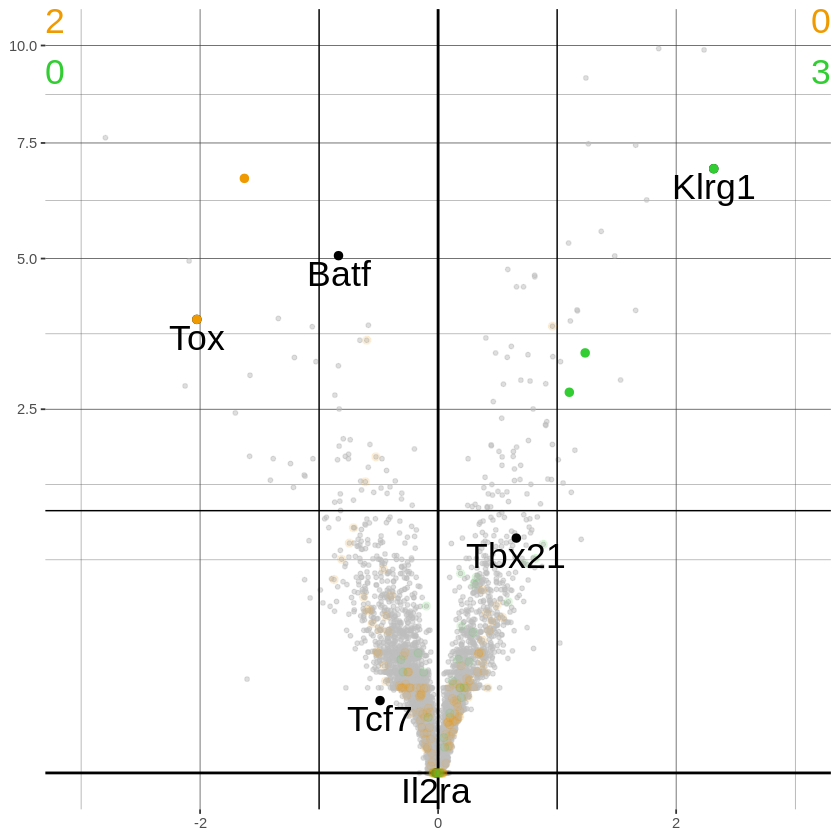

In [108]:
cluster <- c('P2')
cluster_oldname <- cvt_names(cluster, label.df$louvain_new_label, label.df$louvain)
cluster_oldname <- as.character(cluster_oldname)

cp <- c("A", "C")
cp_oldnames <- c("A", "C")

###----- Setup
outname.base <- paste(cluster, cp[1], "vs", cp[2], sep="_")
use.genes <- c("Tbx21", "Il2ra", "Batf", "Tox", "Bach2", "Tcf7", "Tox","Batf3", "Klrg1", "Sell", "Cd127")
log2fc.c <- 1
nlog10p.c <- 1.3
gs.vec <- c("Tex up", "TE up")
gs.col.vec <- c("orange2", "limegreen")
log2fc.range <- c(-3,3)
nlog10pval.max <- 10

###----- Plot
# Read input
louvain.de.file <- paste(cp_oldnames[1], "vs", cp_oldnames[2], "differential.csv", sep="_")
louvain.de.file <- file.path(de.dir, cluster_oldname,file.path(cp_oldnames[1], louvain.de.file))
de.df <- read_csv(louvain.de.file)
# Filter out low expression & convert df for plotting
de.df <- de.df %>% 
  mutate(max_expr = pmax(pull(de.df, cp_oldnames[1]), pull(de.df, cp_oldnames[2]))) %>% filter(max_expr > 0.15) %>% 
  drop_na() %>% select(one_of('gene_names', 't-test_logfc', 't-test_padj'))
colnames(de.df) <- c("gene_name", "log2fc", "padj")
de.df$nlog10pval <- -log10(de.df$padj)
# Plot
vol_plot_out <- volcano_plot_highlightGSEA(de.df, use.genes, gs.vec, gs.col.vec, 
                                           log2fc.c, nlog10p.c,log2fc.range, nlog10pval.max) # With label
vol_plot <- vol_plot_out$plot
vol_plot
ggsave(paste(outname.base, ".png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')

# Save simplified plot
vol_plot <- vol_plot + theme(axis.text.x=element_blank(), axis.text.y=element_blank()) # Without label
ggsave(paste(outname.base, "_nolabel.png", sep=""), vol_plot, device='png', width=10, height=10, units='cm')

# Save summary
write_csv(vol_plot_out$sum, paste(outname.base, "_sum.csv", sep=""))